In [1]:
import json
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
from urllib.request import urlopen
import folium
import branca
import scipy as sp
import scipy.ndimage
import geojsoncontour
from math import radians
from folium import plugins
from scipy.interpolate import griddata
from sklearn.metrics.pairwise import haversine_distances
import folium
from sklearn.cluster import KMeans
from folium.plugins import MousePosition
import warnings
from pyecharts.charts import Pie, Bar, Map, WordCloud,Line,Grid,Scatter,Radar,Page 
from pyecharts import options as opts
from pyecharts.globals import SymbolType
from pyecharts.globals import ThemeType
from pyecharts.charts import Bar, Line, Grid,Tab
from pyecharts.globals import ThemeType
from pyecharts.globals import CurrentConfig, NotebookType
from pyecharts.render import make_snapshot
from pyecharts.commons.utils import JsCode
from pyecharts.charts import Grid, Tab
warnings.filterwarnings("ignore")
from datetime import datetime
from bokeh.plotting import figure, show
from bokeh.plotting import *
from bokeh.models import ColumnDataSource
from bokeh.models import Legend
from bokeh.plotting import figure, show, output_file
from bokeh.palettes import *
from bokeh.resources import CDN
from bokeh.embed import file_html
from bokeh.palettes import Spectral6
from bokeh.transform import factor_cmap
from bokeh.embed import components
from bokeh.io import output_file, show
from bokeh.plotting import figure
from bokeh.embed import file_html
%matplotlib inline

# Social data analysis and visualizations - Final project
### Fire incident analysis in San Francisco

This project aims to determine whether fire incidents have increased in the city of San Francisco. If a difference does exist, we hope to uncover possible explanations for it. Moreover, different socialeconomic factors are also going to be investigated to se if there is any kind of correlation between incidents and these factors.

Here you can find a link to our website: ..

NOTE: the notbooks need to be downloaded and press "Trusted" in the right corner, for all the plots to render correctly.


Fire incidents are a growing concern for many cities, including San Francisco. Understanding the causes and patterns of these incidents is critical in developing strategies for prevention and mitigation. By analyzing past incidents and identifying high-risk areas, we can better allocate resources and take proactive measures to prevent future fires. Mitigating fire incidents not only saves lives and property but also contributes to a safer and more resilient community. Fire prevention is also an environmental concern since fires release toxic smoke and contribute to air pollution. In addition, fighting fires requires significant resources, including water and energy, which can strain already limited resources. By mitigating fire incidents, we can reduce the environmental impact of firefighting and make San Francisco a more sustainable and resilient city.


The following video summarizes the main idea behind our project:

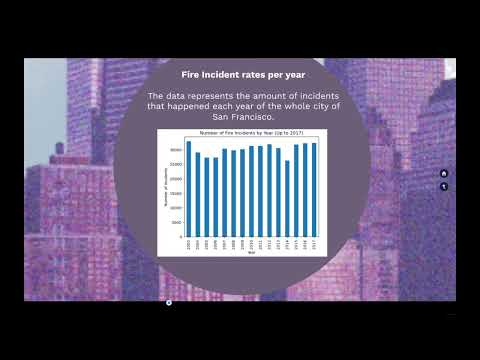

In [7]:
from IPython.lib.display import YouTubeVideo
YouTubeVideo('CoNs8yF8Dlw')

#### What is the idea?

This project aims to determine whether fire incidents have increased in the city of San Francisco. If a difference does exist, we hope to uncover possible explanations for it. Moreover, different socialeconomic factors are also going to be investigated to se if there is any kind of correlation between incidents and these factors.

##### What are your datasets?

For our analysis we choose some different types of dataset to have a more clear view of our problem and to investigate it through different aspects. We will refer to its dataset and the variables later in this notebook.

[Fire incidents](https://data.sfgov.org/Public-Safety/Fire-Incidents/wr8u-xric): Fire incident data; 233 kB, 628k rows, 64 variables.<br>
[Fire inspections](https://data.sfgov.org/Housing-and-Buildings/Fire-Inspections/wb4c-6hwj): Fire inspections; 85 kB, 347k rows, 64 variables.<br>
[Awarded Degrees](https://wad.datausa.io/api/data?Geography=16000US0667000&drilldowns=Degree,Year&measures=Completions): Educational levels; 10 kB, 49k rows, 4 variables.<br>
[Awarded Degrees](https://wad.datausa.io/api/data?Geography=16000US0667000&drilldowns=Gender,Industry_Group,Year&measures=Median_Earnings_by_Industry_and_Gender,Median_Earnings_by_Industry_and_Gender_Moe): Median Earnings ; 28 kB, 57k rows, 6 variables.<br>



##### Why is it interesting?

Studying fire incidents in San Francisco is a compelling topic for analysis due to the unique challenges the city faces in managing and preventing fires. San Francisco's firefighting efforts require innovative strategies and technologies. Moreover, San Francisco has a rich history of major fires which devastated the city and led to the creation of modern firefighting techniques. By analyzing fire incidents in San Francisco, we can gain insights into the effectiveness of current firefighting methods and explore new ways to improve fire prevention and response. Additionally, the lessons learned from studying San Francisco's fires could have broader implications for other cities facing similar challenges, making this research not only interesting but also potentially impactful for public safety and emergency management.

##### What was your goal for the end user's experience?

Our main goal is to communicate ouf findings through a public access web-page. With interactive plots we want the users to choose by themselves different socioeconomic factors and see on maps how fire incidents vary and occur. Plots of data will also be provided to make the user familiar with them as well as other plots that we might find interesting to share when we proceed with our analysis. Last our conclusions will also be presented to complete our story.

In [2]:
df = pd.read_csv('Fire_Incidents.csv')

#### Basic stats. Understanding our dataset better

Before we start analyzing our data we had in some cases to perform some data preprocessing. First we need to declare which category we are going to need and set limits in the date to be until 2020. Then we clean our data for any empty cells.

In [3]:
# select variables that we need
df1 = df[['Incident Number', 'Address', 'Incident Date','Primary Situation','point',"Suppression Personnel",'Action Taken Primary',
          'Item First Ignited','Ignition Cause', 'Alarm DtTm', 'Arrival DtTm',
          'Close DtTm', 'Area of Fire Origin']]

#clean data
df1.dropna(inplace = True)
df2 = df1[df1['Item First Ignited'] != "-"]
df3 = df2[df2['Action Taken Primary'] != "-"]
df4 = df3[df3['Area of Fire Origin'] != "-"] 

# select the date from 2003-01-01 to 2019-12-31
df4['Date'] = df4['Incident Date'].str.slice(0,10)
df5=df4[df4['Date']  <=  "2019-12-31"]

# split the longitudes and  latitude
a = df5.point.str.slice(7,-1)
longitudes = []
latitudes = []

for location in list(a):
    values = str(location).split()
    if len(values) == 1:
        longitude, latitude = None, None
    else:
        longitude, latitude = map(float, values)
    longitudes.append(longitude)
    latitudes.append(latitude)
    
df5['longitude'] = longitudes
df5['latitudes'] = latitudes

##### Areas of incidents

In the map below we can see the exact locations of the incidents that occured each year. The map also reveals that the majority of occurancies take place in the center of the town. The suburbs also seem to be consistent throughout the years.

In [4]:
from ipywidgets import interact
import folium

def plot_fire_incidents(year):
    m = folium.Map(location=[37.7749,-122.4194], zoom_start=12, tiles='Stamen Terrain') 
    data = {
            'latitude': list(df5[df5['Date'].str.contains(year)]["latitudes"]),
            'longitude': list(df5[df5['Date'].str.contains(year)]["longitude"])
            }
    df = pd.DataFrame(data)
    for index, row in df.iterrows():
        folium.CircleMarker([row['latitude'], row['longitude']], radius=0.00001,
                            color='red', fill_color='red', fill_opacity=10).add_to(m)

    X = df5[df5['Date'].str.contains(year)][["latitudes","longitude"]]
    kmeans = KMeans(n_clusters=10, random_state=42)
    kmeans.fit(X)
    centroids = kmeans.cluster_centers_

    MousePosition(position='bottomleft', separator=' | ').add_to(m)
    folium.Marker(location=[centroids[0][0], centroids[0][1]],icon=folium.Icon(icon = "flag",color='blue')).add_to(m)
    folium.Marker(location=[centroids[6][0], centroids[6][1]],icon=folium.Icon(icon = "flag",color='blue')).add_to(m)
    folium.Marker(location=[centroids[8][0], centroids[8][1]],icon=folium.Icon(icon = "flag",color='blue')).add_to(m)
    folium.Marker(location=[centroids[3][0], centroids[3][1]],icon=folium.Icon(icon = "flag",color='blue'),popup='Centroids 1').add_to(m)

    folium.Marker(location=[centroids[2][0], centroids[2][1]],icon=folium.Icon(icon = "star",color='green')).add_to(m)
    folium.Marker(location=[centroids[9][0], centroids[9][1]],icon=folium.Icon(icon = "star",color='green')).add_to(m)
    folium.Marker(location=[centroids[1][0], centroids[1][1]],icon=folium.Icon(icon = "star",color='green')).add_to(m)

    folium.Marker(location=[centroids[5][0], centroids[5][1]],icon=folium.Icon(icon = "cloud",color='gray')).add_to(m)
    folium.Marker(location=[centroids[4][0], centroids[4][1]],icon=folium.Icon(icon = "cloud",color='gray')).add_to(m)

    folium.Marker(location=[centroids[7][0], centroids[7][1]],icon=folium.Icon(icon = "play",color='green')).add_to(m)
    
    return m

interact(plot_fire_incidents, year=list(df5['Date'].str.slice(0, 4).unique()))


interactive(children=(Dropdown(description='year', options=('2008', '2003', '2004', '2005', '2006', '2007', '2…

<function __main__.plot_fire_incidents(year)>

##### Amount of fire incidents

We can see in the graph below that the number of occurancies rose during the years, reaching it's peak at 2007. In 2014 we can notice a sharp decrease and after that the number of incidents keeps decreasing.

In [6]:
# split the number of Primary Situation & Action Taken Primary&'Item First Ignited'&'Item First Ignited'
b = []
c = []
d = []
e = []
f = [] # extract year 
g = [] # extract month
h = [] # extract hour
j = [] # extrat weekofday
for i in range(len(df5)):
    b.append(list(df5['Primary Situation'])[i].split()[0])
    c.append(list(df5["Action Taken Primary"])[i].split()[0])
    d.append(list(df5['Item First Ignited'])[i].split()[0])
    e.append(list(df5['Ignition Cause'])[i].split()[0])
    f.append(list(df5['Date'])[i].split('-')[0])
    g.append(list(df5['Date'])[i].split('-')[1])
    h.append((list(df5['Alarm DtTm'])[i].split("T")[1]).split(":")[0])
    
    date_obj = datetime.strptime(list(df5["Date"])[i],"%Y-%m-%d")
    weekday = date_obj.weekday()
    j.append(weekday)
    

    

df5["Primary Situation_number"] = b   
df5["Action Taken Primary_number"] = c    
df5["Item First Ignited_number"] = d
df5["Ignition Cause_number"] = e
df5["Year"] = f
df5["Month"] = g
df5["Hour"] = h
df5["weekofday"]=j

x_data = list(range(2003,2020))
y_data = list((df5["Year"].sort_values()).value_counts(sort = False))


bar_year = (
    Bar()
    .add_xaxis(x_data)
    .add_yaxis("", y_data,color="#3170c2")
        .set_global_opts(
       
        xaxis_opts=opts.AxisOpts(name="Year"),
        #yaxis_opts=opts.AxisOpts(name="The Amount of The Fire Incident in Northeast of SF "),
    )
    
    .set_series_opts(
        label_opts=opts.LabelOpts(position="inside"),
        markline_opts=opts.MarkLineOpts(
            data=[opts.MarkLineItem(y=np.mean(y_data), name="Average")]
        ),
    )
)
bar_year.set_global_opts(title_opts={"text": "The Amount of The Fire Incident in Northeast of SF By Year"},
    xaxis_opts=opts.AxisOpts(
        axislabel_opts=opts.LabelOpts(
            font_size=12,  
            font_family="Arial",  
            color="#333333", 
            interval=0,  
            rotate=45
        ),
    ),
)
bar_year.render_notebook()

#### Social Data

We saw previously that the number of incidents keeps decreasing and it is important to understand why. There are many factors that affect this outcome, such as the increased amount of inspections that were made. Different laws were also created for fire safety in buildings.

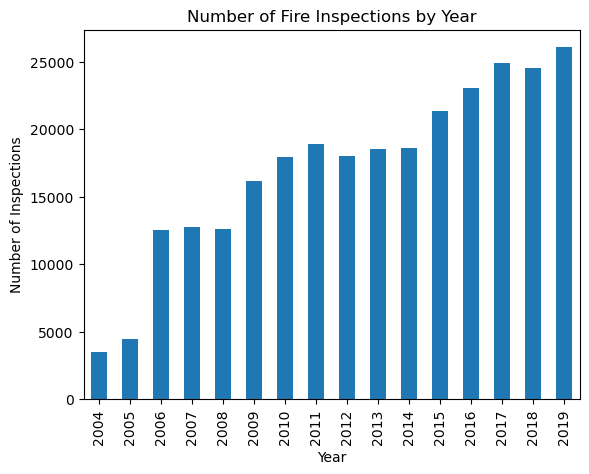

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Import the dataset
df = pd.read_csv('Fire_Inspections.csv')

# Select only the Inspection Start Date column
df = df[['Inspection Start Date']]

# Convert Inspection Start Date to datetime format
df['Inspection Start Date'] = pd.to_datetime(df['Inspection Start Date'])

# Filter the data to only include inspections before 2020
df = df[df['Inspection Start Date'].dt.year < 2020]

# Create a new column for year
df['Year'] = df['Inspection Start Date'].dt.year

# Group by year and count the number of inspections
year_counts = df.groupby('Year').count()

# Plot the bar chart
year_counts.plot(kind='bar', legend=None)
plt.title('Number of Fire Inspections by Year')
plt.xlabel('Year')
plt.ylabel('Number of Inspections')
plt.show()

Another crucial factor that we have to take under consideration is the demographics of the city. Below we will analyze the educational level and the income of the citizens.



We can see that the income rates keep rising through the years, which plays big role in the average amount of spendings that the citizens make in fire safety measures. 

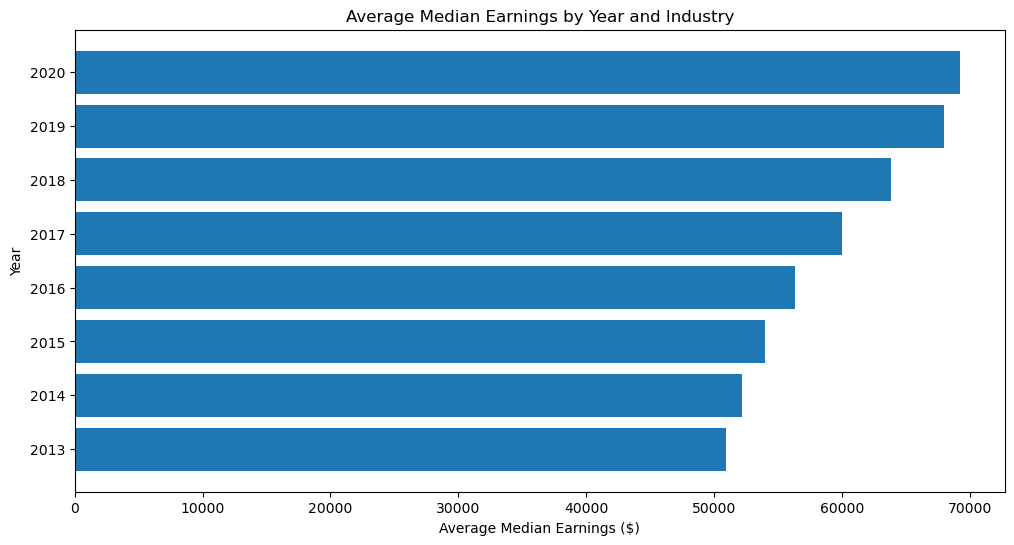

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Import the dataset
df = pd.read_csv('Median.csv')

# Select only the required columns
df = df[['Industry', 'Year', 'Median Earnings by Industry and Gender']]

# Group by year and industry, and calculate the median earnings
earnings_by_year_industry = df.groupby(['Year', 'Industry']).median()

# Calculate the average earnings by year
earnings_by_year = earnings_by_year_industry.groupby('Year').mean()

# Create the horizontal bar chart
fig, ax = plt.subplots(figsize=(12, 6))
ax.barh(earnings_by_year.index, earnings_by_year['Median Earnings by Industry and Gender'])
ax.set_title('Average Median Earnings by Year and Industry')
ax.set_ylabel('Year')
ax.set_xlabel('Average Median Earnings ($)')
plt.show()


The educational level has slightly increased in almost every level. This plays a big role in the way people value safety measures. 

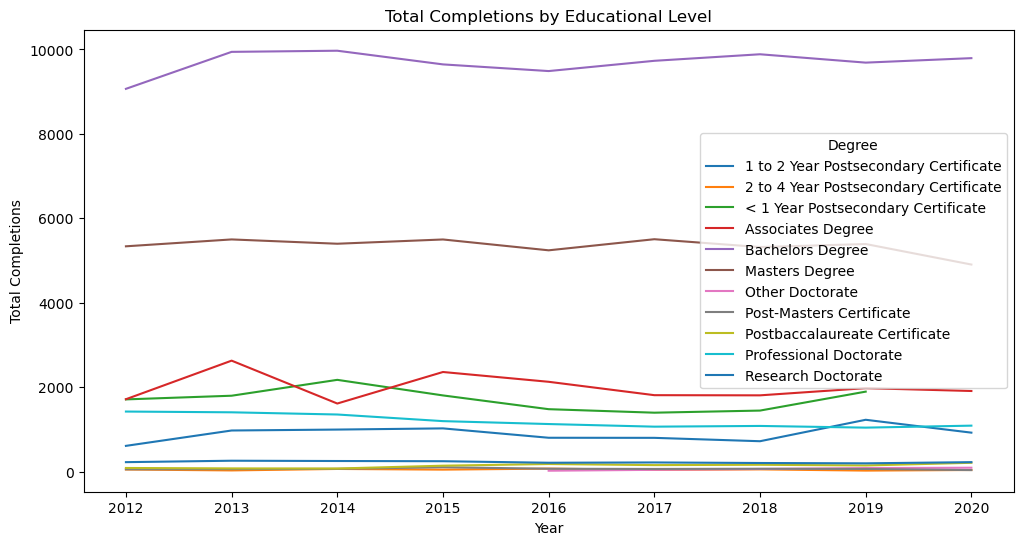

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Import the dataset
df = pd.read_csv('Awarded Degrees over Time.csv')

# Select only the required columns
df = df[['ID Degree', 'Degree', 'ID Year', 'Year', 'Completions']]

# Filter the data to include only years until 2020
df = df[df['Year'] <= 2020]

# Group by degree and year, and calculate the total completions
completions_by_degree_year = df.groupby(['Degree', 'Year']).sum()

# Create a pivot table to reshape the data for plotting
pivot_table = completions_by_degree_year.pivot_table(values='Completions', index='Year', columns='Degree')

# Create the line plot
fig, ax = plt.subplots(figsize=(12, 6))
pivot_table.plot(ax=ax)
ax.set_title('Total Completions by Educational Level')
ax.set_xlabel('Year')
ax.set_ylabel('Total Completions')
plt.show()


### Incident analysis

In order to understand better our data , we need to do more detailed analysis. We also need to identify patterns and try to provide usefull recommendations.

In the graph below we can see that the average number of cases per month are around 2400. We notice that the months with the most occurancies are January and July. The reason why those months have high amounts are propably because in January people tend to use their heating appliances and fireplaces more. July on the other hand is the month with the highest temperatures.

In [11]:
x_data = ['January','February','March','April','May','June','July','August','September','October','November','December']
y_data = list((df5["Month"].sort_values()).value_counts(sort = False))


bar_month = (
    Bar()
    .add_xaxis(x_data)
    .add_yaxis("", y_data,color="#3170c2")
        .set_global_opts(
#         title_opts=opts.TitleOpts(title="Bar Chart of Fire on Primary Situation "),
#         xaxis_opts=opts.AxisOpts(name="Month"),
#         yaxis_opts=opts.AxisOpts(name="The Amount of The Fire Incident in Northeast of SF "),
    )
    
    .set_series_opts(
        label_opts=opts.LabelOpts(position="inside"),
        markline_opts=opts.MarkLineOpts(
            data=[opts.MarkLineItem(y=np.mean(y_data), name="Average")]
        ),
    )
)
bar_month.set_global_opts(title_opts={"text": "The Amount of The Fire Incident in Northeast of SF By Month"},
    xaxis_opts=opts.AxisOpts(
        axislabel_opts=opts.LabelOpts(
            font_size=12,  
            font_family="Arial", 
            color="#333333",  
            interval=0,  
            rotate=45
        ),
    ),
)

bar_month.render_notebook()

In the visualization below , we can see the different patterns that take place during the different hours of every week day. We can clearly see that the majority of incidents happen late in the evening. Sunday seem to the week day with the majority of cases.

In [12]:
DayOfWeek = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
hours = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24']
normalise = pd.DataFrame()
for i in range(7):
    normalise1 = df5[df5.weekofday == i]["Hour"].value_counts().sort_index()
    normalise = pd.concat([normalise,normalise1],axis = 1)
normalise.set_axis(DayOfWeek,axis='columns',inplace=True)
normalise["Hour"] = list(range(1,25))
source_df = ColumnDataSource(normalise)
p = figure(title="The Amount of Fire incidents By Time Period of the Week",x_range = hours ,plot_width = 1200, plot_height = 900,
           x_axis_label='Hour Of Day' ,y_axis_label='The Amount of The Fire Incident in Northeast of SF' )
line ={} 
circle={}
for i in range(7):
    line[i] = p.line(x='Hour',y=DayOfWeek[i], source= source_df,muted_alpha=0.01, muted = True,color= viridis(7)[i],line_width=2, line_alpha = 1) 
    circle[i] = p.circle(x='Hour',y=DayOfWeek[i],source = source_df, size = 2,color = "blue",alpha = 0.7,muted = True)
    
items = [] ### for the custom legend // you need to figure out where to add it
for i in range(7):
    items.append((DayOfWeek[i], [line[i]])) ### figure where to add it

legend = Legend(items=items) ## figure where to add it
p.add_layout(legend, 'left') ## figure where to add it
p.legend.click_policy="mute" ### assigns the click policy (you can try to use ''hide' 

show(p)
html = file_html(p, CDN, "my plot")
with open("temporal168.html", "w") as f:
    f.write(html)